## World Happiness Report

Essa análise foi conduzida com base nos dados disponibilizados pela "Sustainable Development Solutions Network" no Kaggle.   (Mais informações https://www.kaggle.com/unsdsn/world-happiness) .Para essa análise foram considerados os 5 anos de dataset disponibilizados 2015 a 2019. Os dados são de pesquisas realizadas em diferentes países sobre a percepção que os habitantes tem sobre diferentes aspectos sociais de seu país. O intuito desse notebook é trabalhar com o tratamento dos dados, a visualiuzação deles e entender como a percepção dos fatores sociais influenciam na felicidade dessas pessoas.



Significado das colunas:

Country-Nome do país

Region- Região em que o país foi categorizado.

Happiness Rank  -Classificação do país em um determinado ano.

Happiness Score- Pontuação de felicidade

Economy - Quantificação do poder econômico.

Government Trust-  Uma quantificação da confiança percebida das pessoas em seus governos.

Generosity- Valor numérico estimado com base na percepção de generosidade vivida pelos entrevistados em seu país.

Social Support-  Métrica que estima a satisfação das pessoas com seus amigos e familiares.

Freedom-  Percepção de liberdade quantificada.



# Importando Bibliotecas

In [90]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import glob as glob
import geopandas as gpd
from geopy.geocoders import Nominatim
import pycountry
import os
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error


# Trabalhando e tratando os dados

In [2]:
##No Kaggle
# all_files=[]
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         all_files.append(os.path.join(dirname, filename))

    
# #reordenar ordem arquivos
# myorder = [2, 3, 0, 4, 1]
# all_files = [all_files[i] for i in myorder]


In [3]:
#Carregando arquivos .cvs
path = r'E:\PythonFundamentos-master\Treino\Analise felicidade mundo'
all_files = glob.glob(path +'\Dados' + "/*.csv")

#Extraindo nome dos arquivos
year=[os.path.basename(yr)[:4] for yr in all_files]

li = []
i=0
for filename in all_files:
    
    df_temp = pd.read_csv(filename, index_col=None, header=0)
    df_temp['Year']=year[i]
    li.append(df_temp)
    i+=1
    
#Removendo algumas colunas para que todos os arquivos possuam as mesmas informações.
df_2015=li[0].drop(['Standard Error','Dystopia Residual'], axis=1)
df_2016=li[1].drop(['Lower Confidence Interval','Upper Confidence Interval','Dystopia Residual'], axis=1)
df_2017=li[2].drop(['Whisker.high','Whisker.low','Dystopia.Residual'], axis=1)
df_2018=li[3]
df_2019=li[4]



#Renomeando colunas
df_2015.rename(columns={'Economy (GDP per Capita)':'Economy', 'Health (Life Expectancy)':'Life Expectancy',
        'Trust (Government Corruption)':'Government Trust','Family':'Social Support'},inplace=True)

df_2016.rename(columns={'Economy (GDP per Capita)':'Economy', 'Health (Life Expectancy)':'Life Expectancy',
        'Trust (Government Corruption)':'Government Trust','Family':'Social Support'},inplace=True)

df_2017.rename(columns={'Happiness.Rank':'Happiness Rank', 'Happiness.Score':'Happiness Score',
        'Economy..GDP.per.Capita.':'Economy', 'Health..Life.Expectancy.':'Life Expectancy',
        'Trust..Government.Corruption.':'Government Trust','Family':'Social Support'},inplace=True)

df_2018.rename(columns={'Overall rank':'Happiness Rank', 'Country or region':'Country', 'Score':'Happiness Score', 
                        'GDP per capita':'Economy','Social support':'Social Support', 
                        'Healthy life expectancy':'Life Expectancy', 'Freedom to make life choices':'Freedom',                        
                        'Perceptions of corruption':'Government Trust'},inplace=True)

df_2019.rename(columns={'Overall rank':'Happiness Rank', 'Country or region':'Country', 'Score':'Happiness Score', 
                        'GDP per capita':'Economy','Social support':'Social Support', 
                        'Healthy life expectancy':'Life Expectancy', 'Freedom to make life choices':'Freedom',                        
                        'Perceptions of corruption':'Government Trust'},inplace=True)


#Mapping regiões não presentes nos outros anos.
Country_Region=df_2015.set_index('Country')['Region']

df_2017['Region']=df_2017['Country'].map(Country_Region)
df_2018['Region']=df_2018['Country'].map(Country_Region)
df_2019['Region']=df_2019['Country'].map(Country_Region)

df_t=[df_2015,df_2016,df_2017,df_2018,df_2019]


In [4]:
# Verificando Valores nulos
[print('Year',i+2015 , '\n' ,df_t[i].isnull().any()) for i in range(len(list(df_t)))]

Year 2015 
 Country             False
Region              False
Happiness Rank      False
Happiness Score     False
Economy             False
Social Support      False
Life Expectancy     False
Freedom             False
Government Trust    False
Generosity          False
Year                False
dtype: bool
Year 2016 
 Country             False
Region              False
Happiness Rank      False
Happiness Score     False
Economy             False
Social Support      False
Life Expectancy     False
Freedom             False
Government Trust    False
Generosity          False
Year                False
dtype: bool
Year 2017 
 Country             False
Happiness Rank      False
Happiness Score     False
Economy             False
Social Support      False
Life Expectancy     False
Freedom             False
Generosity          False
Government Trust    False
Year                False
Region               True
dtype: bool
Year 2018 
 Happiness Rank      False
Country             False
Happin

[None, None, None, None, None]

In [5]:
#Paises sem Regiões, países que não estavam presentes no df_2015
print('Countries without Region 2017:',df_2017[df_2017['Region'].isnull()]['Country'].index,
list(df_2017[df_2017['Region'].isnull()]['Country']))
print('Countries without Region 2018:',df_2018[df_2018['Region'].isnull()]['Country'].index,
list(df_2018[df_2018['Region'].isnull()]['Country']))
print('Countries without Region 2019:',df_2019[df_2019['Region'].isnull()]['Country'].index,
list(df_2019[df_2019['Region'].isnull()]['Country']))

Countries without Region 2017: Int64Index([32, 49, 70, 92, 110, 146], dtype='int64') ['Taiwan Province of China', 'Belize', 'Hong Kong S.A.R., China', 'Somalia', 'Namibia', 'South Sudan']
Countries without Region 2018: Int64Index([37, 48, 57, 97, 118, 153], dtype='int64') ['Trinidad & Tobago', 'Belize', 'Northern Cyprus', 'Somalia', 'Namibia', 'South Sudan']
Countries without Region 2019: Int64Index([38, 63, 83, 111, 112, 119, 155], dtype='int64') ['Trinidad & Tobago', 'Northern Cyprus', 'North Macedonia', 'Somalia', 'Namibia', 'Gambia', 'South Sudan']


In [6]:
#Adicionando Regiões a esses Países
df_2017.loc[list(df_2017[df_2017['Region'].isnull()]['Country'].index),'Region']=['Eastern Asia','Latin America and Caribbean','Eastern Asia','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa']
df_2018.loc[list(df_2018[df_2018['Region'].isnull()]['Country'].index),'Region']=['Latin America and Caribbean','Latin America and Caribbean','Middle East and Northern Africa','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa']
df_2019.loc[list(df_2019[df_2019['Region'].isnull()]['Country'].index),'Region']=['Latin America and Caribbean','Middle East and Northern Africa','Central and Eastern Europe','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa','Sub-Saharan Africa']


In [7]:
#Verificando valor nulo em 2018
df_2018[df_2018['Government Trust'].isnull()]

,Happiness Rank,Country,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Generosity,Government Trust,Year,Region
19,20,United Arab Emirates,6.774,2.096,0.776,0.67,0.284,0.186,NaN,2018,Middle East and Northern Africa


In [8]:
#Valores de confiança no governo para os outros anos
for j in range(len(df_t)):
    print('Year:',j+2015,df_t[j][df_t[j]['Country']=='United Arab Emirates']['Government Trust'])

Year: 2015 19    0.38583
Name: Government Trust, dtype: float64
Year: 2016 27    0.35561
Name: Government Trust, dtype: float64
Year: 2017 20    0.32449
Name: Government Trust, dtype: float64
Year: 2018 19   NaN
Name: Government Trust, dtype: float64
Year: 2019 20    0.182
Name: Government Trust, dtype: float64


In [9]:
#Setando valor em 2018 como a média entre 2017 e 2019
df_2018.loc[list(df_2018[df_2018['Government Trust'].isnull()].index),'Government Trust']=list((df_2017[df_2017['Country']=='United Arab Emirates']['Government Trust']+df_2019[df_2019['Country']=='United Arab Emirates']['Government Trust'])/2)

In [10]:
#Concatenando Dataframes
df = pd.concat(df_t, axis=0, ignore_index=True)

#Renomeando alguns paises,  necessario para analises futuras no  Geopandas e Pycountry
df.replace(['Congo (Brazzaville)', 'Congo (Kinshasa)','Swaziland','South Korea','Laos','Ivory Coast','Trinidad & Tobago','Hong Kong S.A.R., China','Taiwan Province of China','Niger'], 
           ['Congo, The Democratic Republic of the','Congo','Eswatini','Korea, Republic of','Lao',"Côte d'Ivoire",'Trinidad and Tobago','Hong Kong Special Administrative Region of China','Taiwan, Province of China','Republic of the Niger'],inplace=True)
#Removendo paises nao reconhecidos
remove = ['North Cyprus','Somaliland region','Swaziland','Palestinian Territories','Somaliland Region','Northern Cyprus']
for r in remove:
    df.drop(list(df[df["Country"]==r].index), inplace=True)   


In [11]:
#Mapping regioes faltantes
Country_Region_C=df.drop_duplicates('Country',keep='first')[['Country','Region']].set_index('Country')


# Criando GeoDataFrame

In [12]:
##Metodo  para encontrar Latitude e Longitude
# geolocator = Nominatim(user_agent="My_app")
# country_location=[]
# for country  in  df['Country'].unique():
#     try:
#         location = geolocator.geocode(country)
#         a=[country,location.latitude, location.longitude]
#         country_location.append(a)
#     except:
#         pass
    

In [13]:
#Encontrando Codigo Iso Alpha3 para os paises, ex Brasil=BRA
i=0
country_location=[]
for c in df['Country'].unique():
    try:
        alph3=pycountry.countries.search_fuzzy(c)[0].alpha_3
        a=[c,alph3]
        
        country_location.append(a)
    except:
        pass
    i+=1
    

In [14]:
#Verificando se todos os paises foram encontrados
nf=[]
for c in df['Country'].unique():
     if c in [cl[0] for cl  in country_location]:
         pass
     else:
         print('Country not found:',c)
         nf.append(c)

In [15]:
# Scaling dados
scaled_data=StandardScaler().fit_transform(df.loc[:,'Happiness Score':'Generosity'])
df_scale=pd.DataFrame(scaled_data,columns=df.loc[:,'Happiness Score':'Generosity'].columns)
df_scale['Year']=df['Year'].reset_index(drop=True)
df_scale['Region']=df['Region'].reset_index(drop=True)
df_scale['Country']=df['Country'].reset_index(drop=True)


In [16]:
df_scale

,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Government Trust,Generosity,Year,Region,Country
0,1.945318,1.177224,0.817381,1.329252,1.656109,2.789288,0.642385,2015,Western Europe,Switzerland
1,1.922385,0.945874,0.976654,1.355043,1.415887,0.156178,1.786835,2015,Western Europe,Iceland
2,1.892396,1.002760,0.850825,1.060517,1.550424,3.392766,1.008311,2015,Western Europe,Denmark
3,1.887986,1.330712,0.761310,1.103046,1.683264,2.271331,1.054246,2015,Western Europe,Norway
4,1.804192,1.004749,0.736114,1.185208,1.443303,1.935866,1.965737,2015,North America,Canada
...,...,...,...,...,...,...,...,...,...,...
765,-1.805982,-1.371112,-1.111623,0.011808,0.934333,2.706225,-0.012031,2019,Sub-Saharan Africa,Rwanda
766,-1.896831,-1.083736,-0.585951,-0.450905,0.033501,0.208683,0.471932,2019,Sub-Saharan Africa,Tanzania
767,-1.921528,-1.393218,-1.697717,-1.006160,-2.688580,-0.945484,-0.495994,2019,Southern Asia,Afghanistan
768,-2.027373,-2.189028,-3.259628,-2.036200,-1.219831,-0.850880,0.135619,2019,Sub-Saharan Africa,Central African Republic


In [17]:
#Adicionando coluna alph3 no dataframe agrupado por pais
df_cl=pd.DataFrame(country_location,columns=['Country','Alpha3'])
df_cl.set_index('Country',inplace=True)
df_c=df_scale.groupby(df['Country']).mean()
df_c['Alpha3']=df_c.index.map(df_cl['Alpha3'])



In [18]:
#Transformando dataframe em geodataframe
gdf = gpd.GeoDataFrame(df_c).reset_index()
gdf['Region']=gdf['Country'].map(Country_Region_C['Region'])


# Plotando mapas coroplético

Como houve agrupamento dos dados por país os gráficos abaixo são plotados a partir da média dos valores dos anos de 2015 a 2019. Países sem dados estao em cinza.

In [118]:
#Acessando mapa geométrico database do geopandas
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world=world[(world['name']!="Antarctica")]
#Alguns códigos alpha iso3 faltando no  mapa base
world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

In [119]:
#Mapeando dados geométricos no geodataframe
gdf['geometry']=gdf['Alpha3'].map(world.drop_duplicates(['iso_a3']).set_index(['iso_a3'])['geometry'])

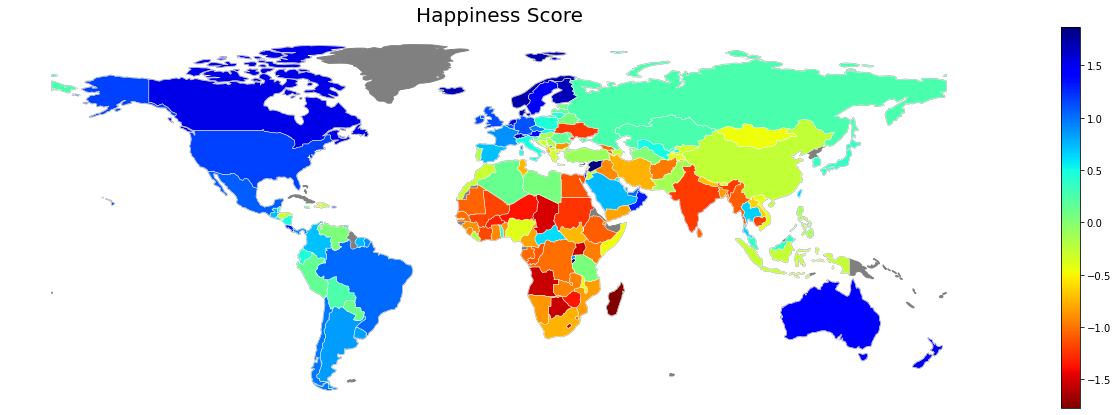

In [21]:
#Happines Score map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='grey')
gdf.plot(ax=base,column='Happiness Score',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5)
ax.set_title("Happiness Score",fontsize=20)
ax.set_axis_off()

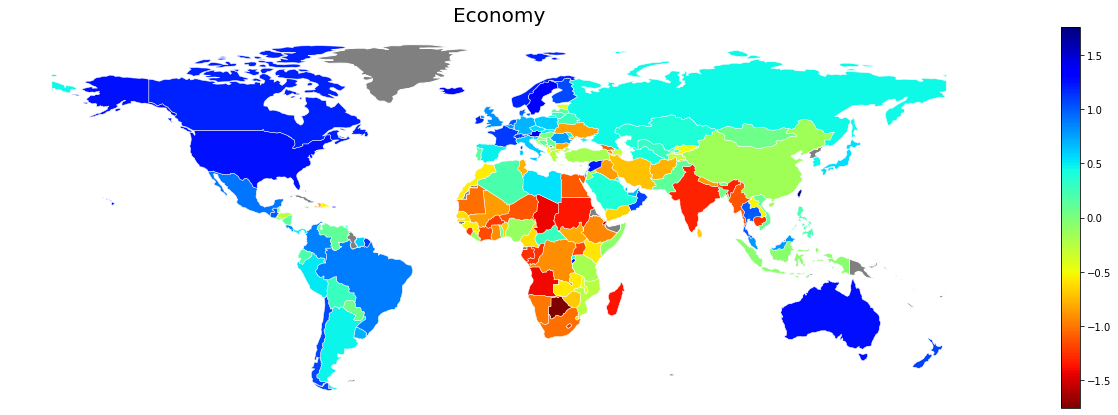

In [22]:
#Economy map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Economy',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Economy",fontsize=20)
ax.set_axis_off()

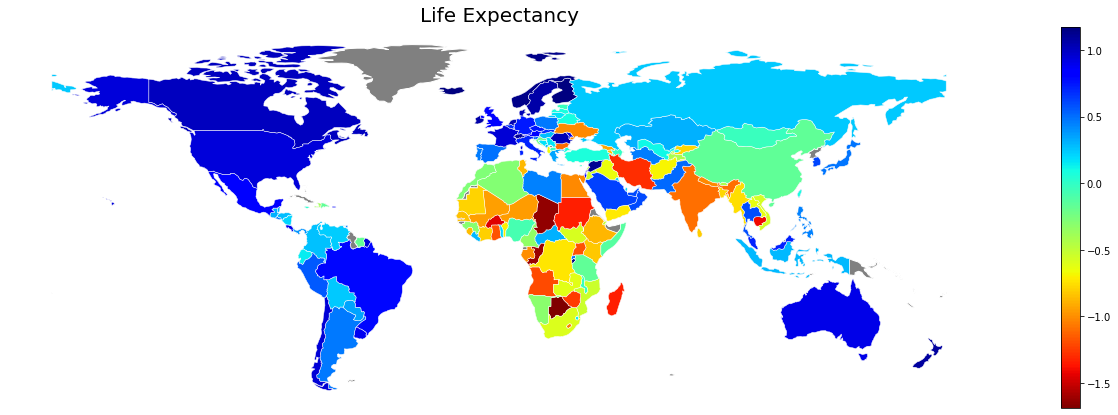

In [23]:
#Life Expectancy map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Life Expectancy',legend=True,cmap='jet_r' ,edgecolor='white',linewidth=0.5)
ax.set_title("Life Expectancy",fontsize=20)
ax.set_axis_off()

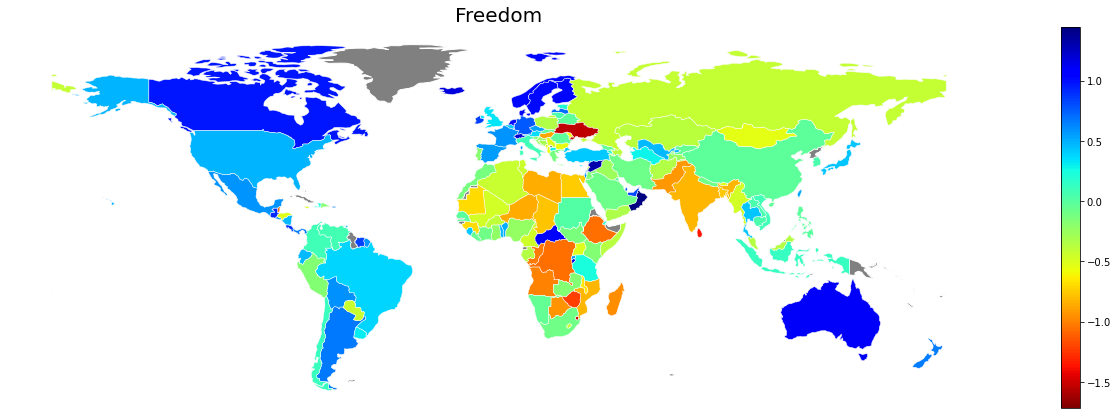

In [24]:
#Freedom map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Freedom',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Freedom",fontsize=20)
ax.set_axis_off()

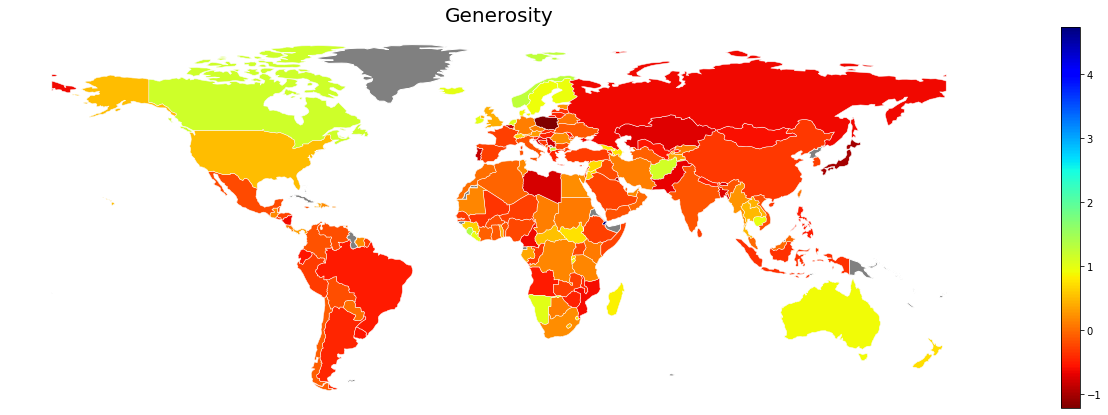

In [25]:
#Generosity map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Generosity',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Generosity",fontsize=20)
ax.set_axis_off()

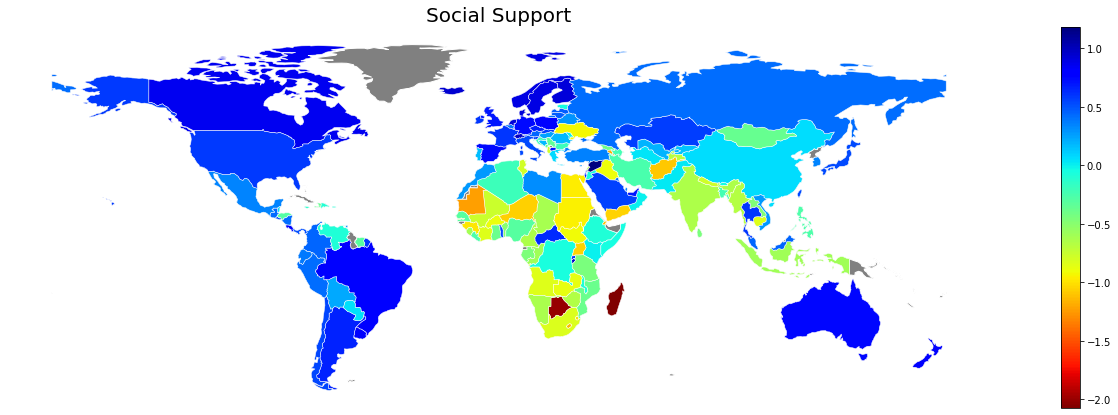

In [26]:
#Social Support map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Social Support',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Social Support",fontsize=20)
ax.set_axis_off()

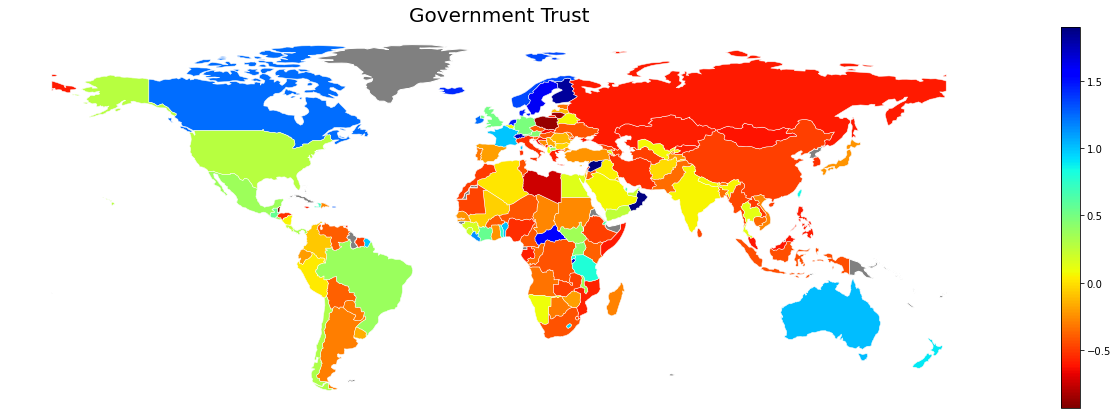

In [27]:
#Government Trust map
fig, ax = plt.subplots(figsize=(25,7))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Government Trust',legend=True,cmap='jet_r',edgecolor='white',linewidth=0.5 )
ax.set_title("Government Trust",fontsize=20)
ax.set_axis_off()

# Analisando os Dados

In [28]:
#DataFrame descrição
df_scale.describe()

,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Government Trust,Generosity
count,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02,7.700000e+02
mean,8.708762e-16,-3.630573e-16,-4.296707e-17,-1.516824e-16,3.125927e-16,2.083470e-17,2.649396e-16
std,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00,1.000650e+00
min,-2.371367e+00,-2.252889e+00,-3.259628e+00,-2.458677e+00,-2.688580e+00,-1.181994e+00,-1.792030e+00
25%,-7.759839e-01,-7.632016e-01,-6.331939e-01,-6.882364e-01,-6.605971e-01,-6.712036e-01,-7.072151e-01
50%,-5.117075e-02,1.608338e-01,1.383129e-01,1.454295e-01,1.270437e-01,-3.306488e-01,-1.350724e-01
75%,7.208315e-01,7.834381e-01,7.614231e-01,7.900207e-01,7.813069e-01,2.923841e-01,5.023232e-01
max,2.105849e+00,2.895314e+00,1.707066e+00,2.132240e+00,2.037526e+00,4.039289e+00,5.082501e+00


<AxesSubplot:xlabel='Region', ylabel='Happiness Score'>

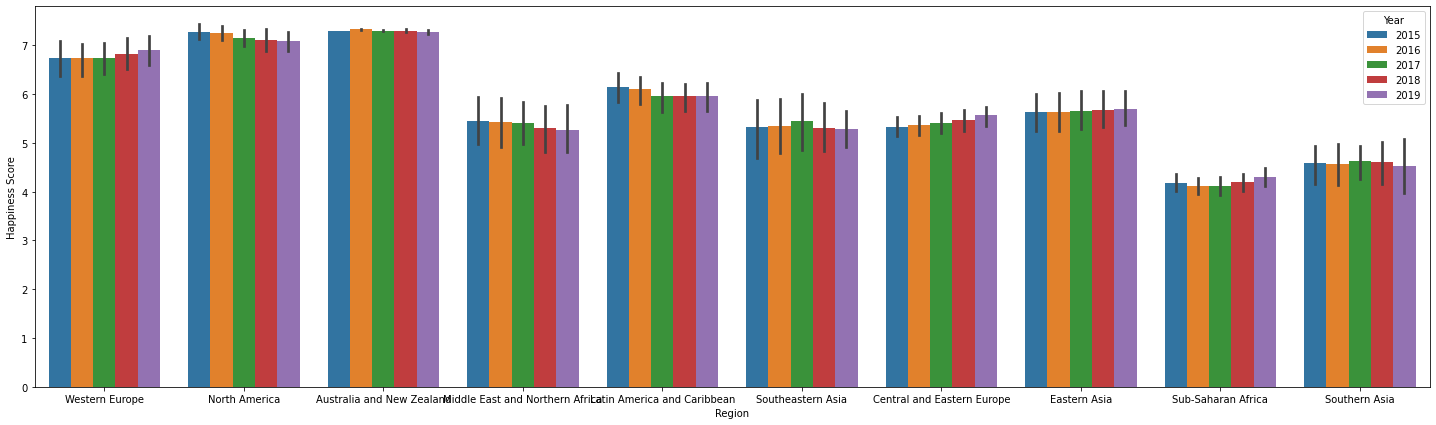

In [29]:
#Visualização do nivel de Felicidade por ano e por regiao
fig, ax = plt.subplots(figsize=(25,7))
sns.barplot(x=df['Region'],y=df['Happiness Score'],hue=df['Year'])

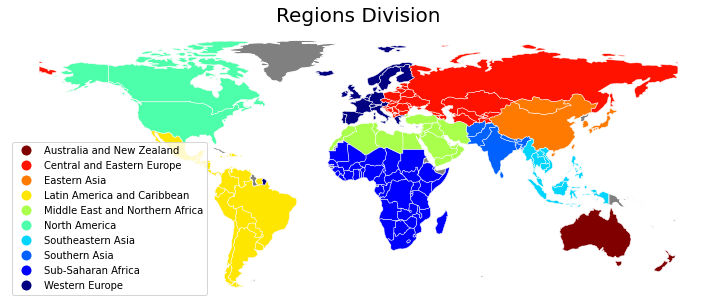

In [30]:
#Divisao das regioes
fig, ax = plt.subplots(figsize=(20,5))
base = world.plot(ax=ax,color='grey', edgecolor='white')
gdf.plot(ax=base,column='Region',cmap='jet_r',edgecolor='white',linewidth=0.5,legend=True, legend_kwds={'loc': 'lower left'} )
ax.set_title("Regions Division",fontsize=20)
ax.set_axis_off()

<AxesSubplot:>

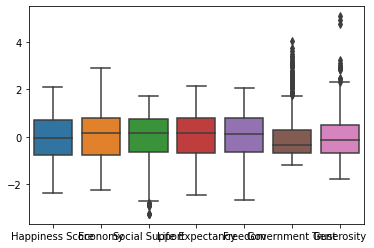

In [123]:
sns.boxplot(data=df_scale.iloc[:,0:7])

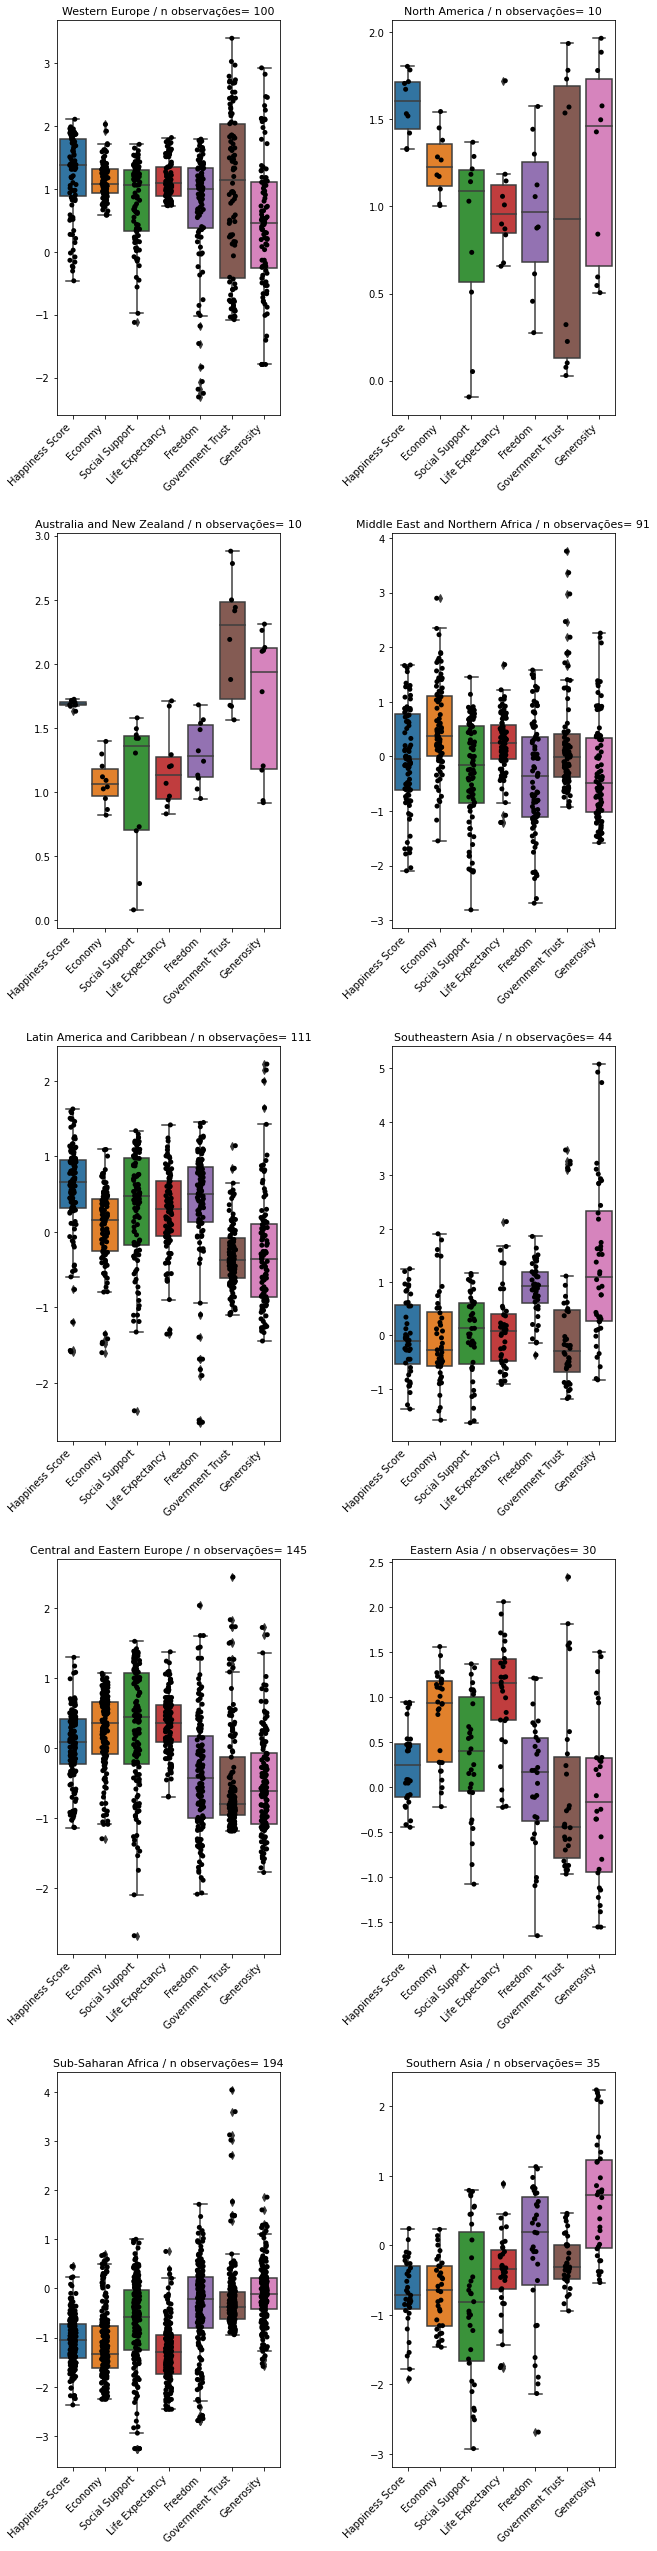

In [32]:
#Verifying data distribution
fig = plt.figure(figsize=(10,45))
i=0
for reg in list(df['Region'].unique()):  
    ax=plt.subplot(5,2,i+1)
    
    sns.boxplot(data=df_scale[df_scale['Region']==reg].iloc[:,0:7])
    
    ax = sns.stripplot(data=df_scale[df_scale['Region']==reg].iloc[:,0:7],
                   color="black", edgecolor="gray")
    
    t=str(reg+' / n observações= '+str(df_scale.groupby('Region').count().loc[reg][0]))
    ax.set_title(t,fontsize=11)
    plt.xticks(rotation=45,ha='right');
    i+=1
plt.subplots_adjust(hspace=0.3,wspace=0.5)

<Figure size 360x360 with 0 Axes>

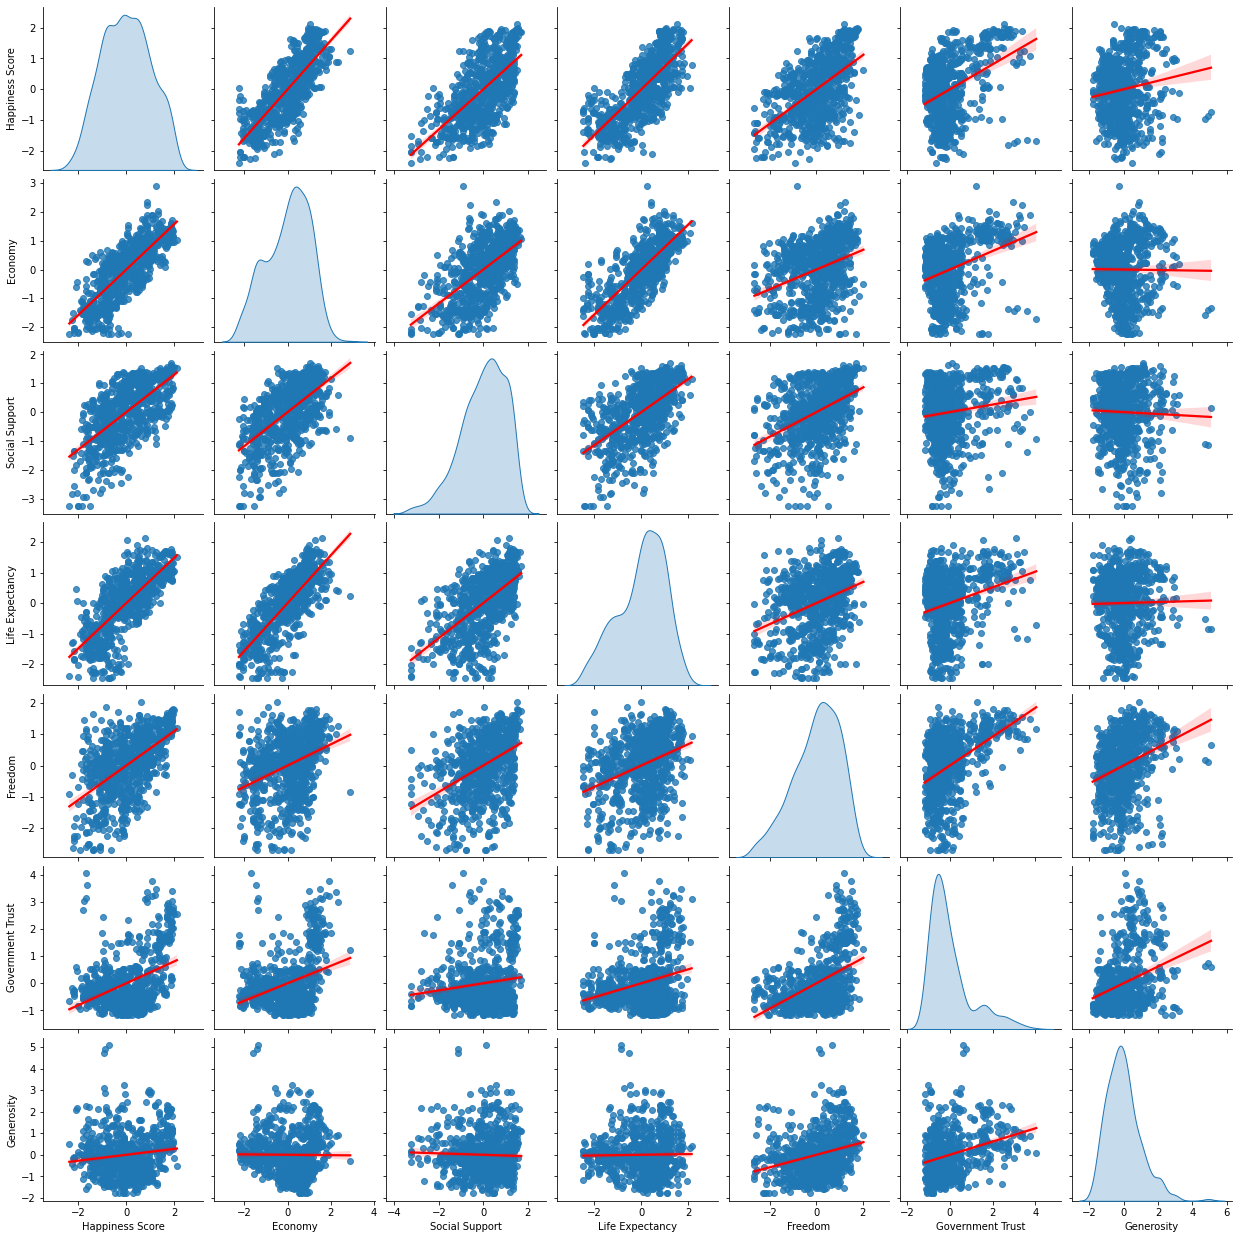

In [33]:
#Pair plot
plt.figure(figsize=(5,5));
sns.pairplot(df_scale.iloc[:,0:7],diag_kind='kde',kind='reg',plot_kws={'line_kws':{'color':'red'}});

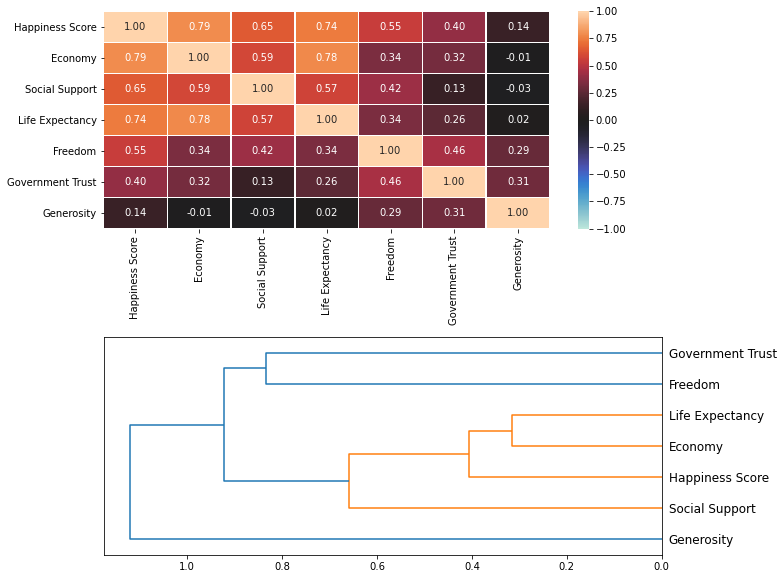

In [34]:
#Correlation map
fig= plt.figure(figsize=(10,10))

ax1=plt.subplot(2,1,1)
ax2=plt.subplot(2,1,2)  
sns.heatmap(df_scale.corr(), annot=True, fmt=".2f", linewidths=.5,vmin=-1, vmax=1, center= 0,ax=ax1)
Z = hierarchy.linkage(df_scale.corr())
dn=hierarchy.dendrogram(Z,labels=df_scale.columns[:-3],leaf_rotation=0, orientation="left",ax=ax2)
plt.subplots_adjust(hspace=0.5,wspace=0.5)    
   

# Regressão 

In [75]:
#Calcular posição do pais para cada feature  para  cada  ano %
for yr in list(df_scale['Year'].unique()):
    for col in df_scale.columns[0:7]:
        df_scale.loc[df_scale['Year'] == yr,str('Ranking '+col)]=  round(df_scale.loc[df_scale['Year'] == yr, col].rank(method='dense',ascending=False)/df_scale.loc[df_scale['Year'] == yr, col].count()*100,2)

In [103]:
#Divisao dados scaled
SEED=np.random.seed(41)
Xs=df_scale.iloc[:,1:7]

ys=df_scale.iloc[:,0]

##Para estrafificar dados  continuos
# #Regra de Sturger qquantidade de bins
# nbins=np.around(1+10/3*np.log10(ys_pre.count())).astype(int)
# #divisao dos bins
# bins=pd.cut(ys_pre,nbins,labels=np.linspace(1,nbins,nbins))
# bins.name='bins'
# ys=pd.concat([ys_pre,bins],axis=1)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys,test_size=0.30,random_state=SEED)
Xsc_train = sm.add_constant(Xs_train)
Xsc_test = sm.add_constant(Xs_test)

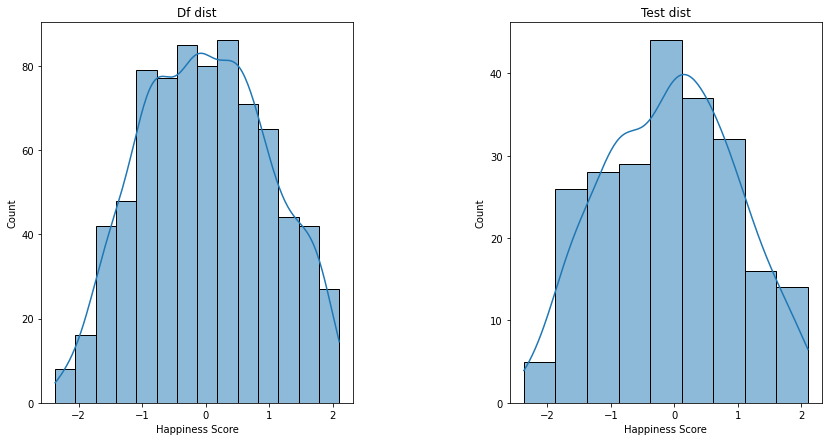

In [104]:
fig= plt.figure(figsize=(14,7))
plt.subplots_adjust(hspace=0.5,wspace=0.5)    

ax1=plt.subplot(1,2,1)
ax1.set_title('Df dist')
sns.histplot(ys_pre,ax=ax1,kde=True);

ax2=plt.subplot(1,2,2)
ax2.set_title('Test dist')
sns.histplot(ys_test,ax=ax2,kde=True);

In [79]:
#verificando Multicolinearidade dos dados >5 ok
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF=pd.Series([variance_inflation_factor(Xs.values,i) for i in range(Xs.shape[1])], index=Xs.columns)
print(VIF)

Economy             2.972890
Social Support      1.840004
Life Expectancy     2.756752
Freedom             1.614245
Government Trust    1.452837
Generosity          1.180679
dtype: float64


                            OLS Regression Results                            
Dep. Variable:        Happiness Score   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     308.6
Date:                Wed, 21 Oct 2020   Prob (F-statistic):          1.24e-169
Time:                        15:00:44   Log-Likelihood:                -355.82
No. Observations:                 539   AIC:                             725.6
Df Residuals:                     532   BIC:                             755.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0201      0.020  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


MSE= 0.27594133145746513


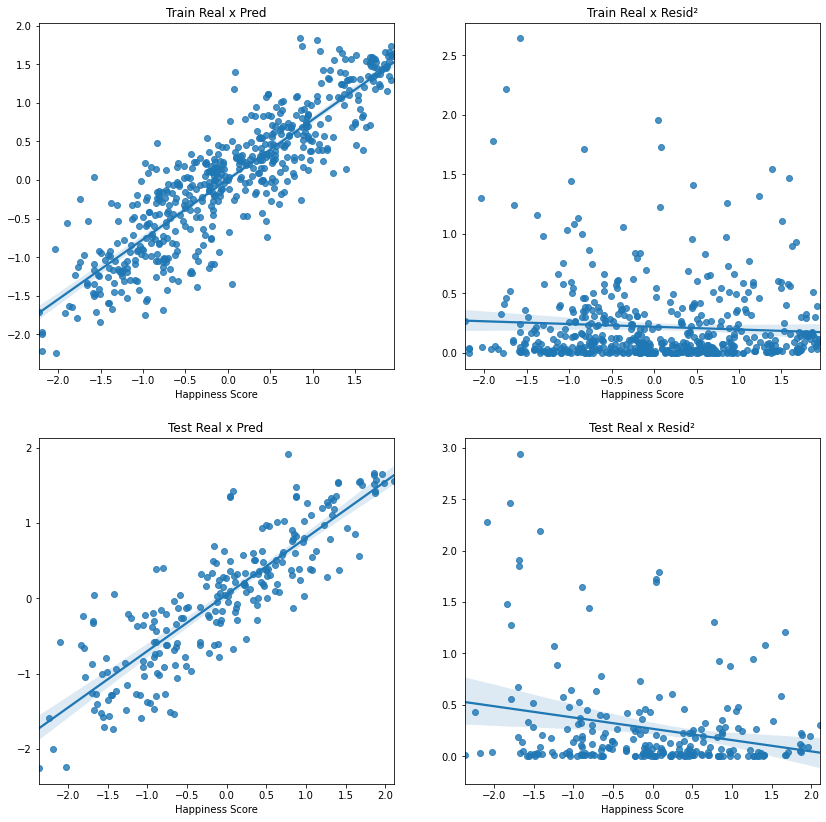

In [105]:
mOLS_scale=sm.OLS(ys_train,Xsc_train)
lr_scale=mOLS_scale.fit()
print(lr_scale.summary())


predict_train=lr_scale.predict(Xsc_train)
residual_train=lr_scale.resid

predict_test=lr_scale.predict(Xsc_test)
residual_test=ys_test-predict_test

print('R2_Test=',sk.metrics.r2_score(ys_test,predict_test))


#Verificar Heterostacidade p>0.05 para regeitar hHeterostacidade
from statsmodels.stats import diagnostic as diag
bp_train_scale=diag.het_breuschpagan(residual_train,Xs_train)

print('='*100)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_train_scale)))

#Verificar autocorelaçao  p>0.05 para regeitar auto
lag=min(10,len(Xs_train)//5)
print('='*100)
print('p_value',min(diag.acorr_ljungbox(residual_train,lags=lag)[1]))


fig= plt.figure(figsize=(14,14))
#plt.subplots_adjust(hspace=0.5,wspace=0.5)    

ax1=plt.subplot(2,2,1)
ax1.set_title('Train Real x Pred')
sns.regplot(x=ys_train,y=predict_train,ax=ax1);

ax2=plt.subplot(2,2,2)
ax2.set_title('Train Real x Resid²')
sns.regplot(x=ys_train,y=residual_train**2,ax=ax2);

ax3=plt.subplot(2,2,3)
ax3.set_title('Test Real x Pred')
sns.regplot(x=ys_test,y=predict_test,ax=ax3);

ax4=plt.subplot(2,2,4)
ax4.set_title('Test Real x Resid²')
sns.regplot(x=ys_test,y=residual_test**2,ax=ax4);

OLS_coef=lr_scale.params
OLS_coef=pd.Series(OLS_coef,name='OLS')

OLS_MSE=mean_squared_error(ys_test,predict_test)
print('MSE=',OLS_MSE)

<AxesSubplot:ylabel='Count'>

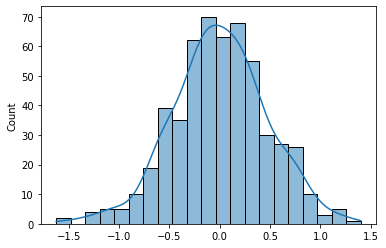

In [106]:
sns.histplot(residual_train,kde=True)

In [107]:
residual_train.describe()

count    5.390000e+02
mean     8.980654e-17
std      4.686699e-01
min     -1.624635e+00
25%     -2.924645e-01
50%     -6.270902e-03
75%      2.969125e-01
max      1.397864e+00
dtype: float64

R2_Train= 0.7765366813194148
R2_Test= 0.7317890745537747
{'LM Statistic': 17.83117470005246, 'LM-Test p-value': 0.003165604064412723, 'F-Statistic': 3.039327390587921, 'F-Test p-value': 0.006237315588477199}
p_value 0.47413422112673265


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


MSE= 0.2773708447961037
Residuals 
 count    539.000000
mean       0.003636
std        0.468917
min       -1.593915
25%       -0.280702
50%       -0.015690
75%        0.295611
max        1.402028
Name: Happiness Score, dtype: float64


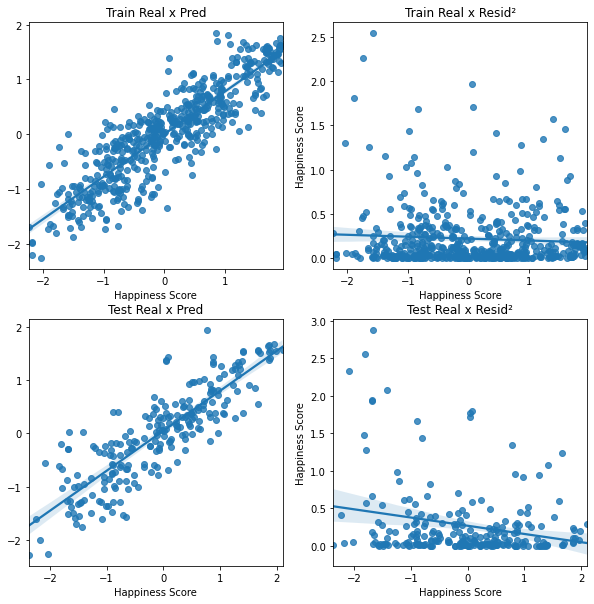

In [111]:
mSGD=SGDRegressor()
mSGD.fit(Xs_train,ys_train)


predict_train=mSGD.predict(Xs_train)
residual_train=ys_train-predict_train

predict_test=mSGD.predict(Xs_test)
residual_test=ys_test-predict_test

print('R2_Train=',sk.metrics.r2_score(ys_train,predict_train))
print('R2_Test=',sk.metrics.r2_score(ys_test,predict_test))

#Verificar Heterostacidade p>0.05 para regeitar hHeterostacidade

from statsmodels.stats import diagnostic as diag
bp_test=diag.het_breuschpagan(residual_train,Xs_train)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print('='*100)
print(dict(zip(labels, bp_test)))

#Verificar autocorelaçao  p>0.05 para regeitar auto
lag=min(10,len(Xs_train)//5)
print('='*100)
print('p_value',min(diag.acorr_ljungbox(residual_train,lags=lag)[1]))

fig= plt.figure(figsize=(10,10))
#plt.subplots_adjust(hspace=0.5,wspace=0.5)    

ax1=plt.subplot(2,2,1)
ax1.set_title('Train Real x Pred')
sns.regplot(x=ys_train,y=predict_train,ax=ax1);

ax2=plt.subplot(2,2,2)
ax2.set_title('Train Real x Resid²')
sns.regplot(x=ys_train,y=residual_train**2,ax=ax2);

ax3=plt.subplot(2,2,3)
ax3.set_title('Test Real x Pred')
sns.regplot(x=ys_test,y=predict_test,ax=ax3);

ax4=plt.subplot(2,2,4)
ax4.set_title('Test Real x Resid²')
sns.regplot(x=ys_test,y=residual_test**2,ax=ax4);

mSGD_coef= mSGD.coef_
mSGD_intercept=mSGD.intercept_
mSGD_param=np.concatenate([mSGD_intercept,mSGD_coef])
mSGD_param=pd.Series(mSGD_param, name='SGD',index=['const','Economy','Social Support','Life Expectancy','Freedom','Government Trust','Generosity'])

mSGD_MSE=mean_squared_error(ys_test,predict_test)
print('MSE=',mSGD_MSE)

print('Residuals \n',residual_train.describe())




<AxesSubplot:xlabel='Happiness Score', ylabel='Count'>

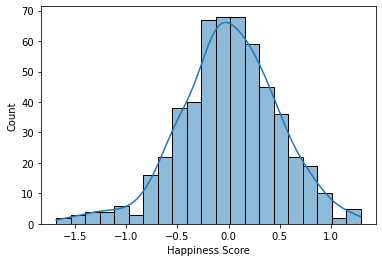

In [84]:
sns.histplot(residual_train,kde=True)

                       OLS       SGD
const             0.020096  0.016385
Economy           0.384368  0.360214
Social Support    0.177225  0.187047
Life Expectancy   0.255740  0.273550
Freedom           0.197674  0.190393
Government Trust  0.103951  0.109456
Generosity        0.052445  0.053405


<AxesSubplot:>

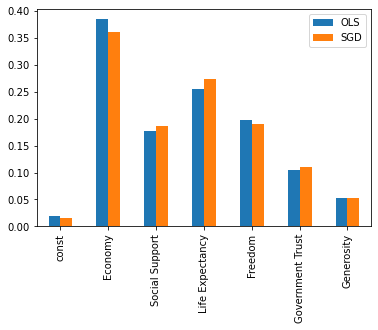

In [113]:
coefs=pd.concat([OLS_coef,mSGD_param],axis=1)
print(coefs)
coefs.plot(kind='bar')

In [88]:
resd=residual_train
sig2sup=residual_train.std()*2+residual_train.mean()
sig2inf=-residual_train.std()*2+residual_train.mean()

bottom=resd[resd<sig2inf]
top=resd[resd>sig2sup]
idx=(top+bottom).index

df_tb=df_scale.loc[idx,:]
df_tb['Residual']=pd.concat([top,bottom])
df_tb['tb']='Sobre Estimados'
for ind in top.index:
    df_tb.loc[ind,'tb']='Sub Estimados'
    
df_tb.sort_values('tb',inplace=True)       


In [114]:
df_tb

,Happiness Score,Economy,Social Support,Life Expectancy,Freedom,Government Trust,Generosity,Year,Region,Country,Ranking Happiness Score,Ranking Economy,Ranking Social Support,Ranking Life Expectancy,Ranking Freedom,Ranking Government Trust,Ranking Generosity,Residual,tb
766,-1.896831,-1.083736,-0.585951,-0.450905,0.033501,0.208683,0.471932,2019,Sub-Saharan Africa,Tanzania,97.40,77.27,77.27,56.49,39.61,20.13,11.69,-1.312323,Sobre Estimados
448,-1.424942,0.503203,0.430816,-1.083592,0.609226,-0.249358,-0.977099,2017,Sub-Saharan Africa,Botswana,88.89,42.48,55.56,77.12,28.76,44.44,86.93,-1.463645,Sobre Estimados
765,-1.805982,-1.371112,-1.111623,0.011808,0.934333,2.706225,-0.012031,2019,Sub-Saharan Africa,Rwanda,96.75,81.82,85.71,48.05,11.04,1.30,28.57,-1.521346,Sobre Estimados
457,-1.685143,-1.347174,-0.402549,-1.145277,1.109564,3.124564,0.281267,2017,Sub-Saharan Africa,Rwanda,94.77,89.54,82.35,78.43,12.42,1.31,41.18,-1.373899,Sobre Estimados
459,-1.792751,-0.997435,-0.111669,-0.992040,-0.142633,-0.557276,1.113850,2017,Sub-Saharan Africa,Tanzania,96.08,83.01,75.16,75.16,62.75,66.01,19.61,-1.134518,Sobre Estimados
536,0.042766,1.198077,0.637596,1.685622,0.731972,1.570979,0.225849,2018,Eastern Asia,Hong Kong,48.05,5.84,43.51,0.65,37.66,8.44,20.13,-1.255487,Sobre Estimados
575,-0.803107,0.001906,0.710102,0.245176,1.130166,-0.708974,0.726218,2018,Southern Asia,Sri Lanka,72.73,48.70,40.91,40.26,21.43,55.19,9.74,-1.201656,Sobre Estimados
605,-1.580180,0.245070,0.287148,-0.780839,0.947389,-0.311638,-1.447514,2018,Sub-Saharan Africa,Botswana,92.21,38.96,58.44,68.18,26.62,38.31,74.68,-1.599988,Sobre Estimados
288,-1.241478,0.434836,-0.565227,-1.060398,0.189449,-0.163204,-0.772837,2016,Sub-Saharan Africa,Botswana,85.71,42.86,40.91,77.27,35.06,48.05,82.47,-0.983982,Sobre Estimados
612,-1.833325,-1.135316,-0.265714,-0.925689,0.451278,-0.264336,0.422715,2018,Sub-Saharan Africa,Tanzania,96.75,78.57,72.08,71.43,44.81,35.71,16.23,-1.213479,Sobre Estimados


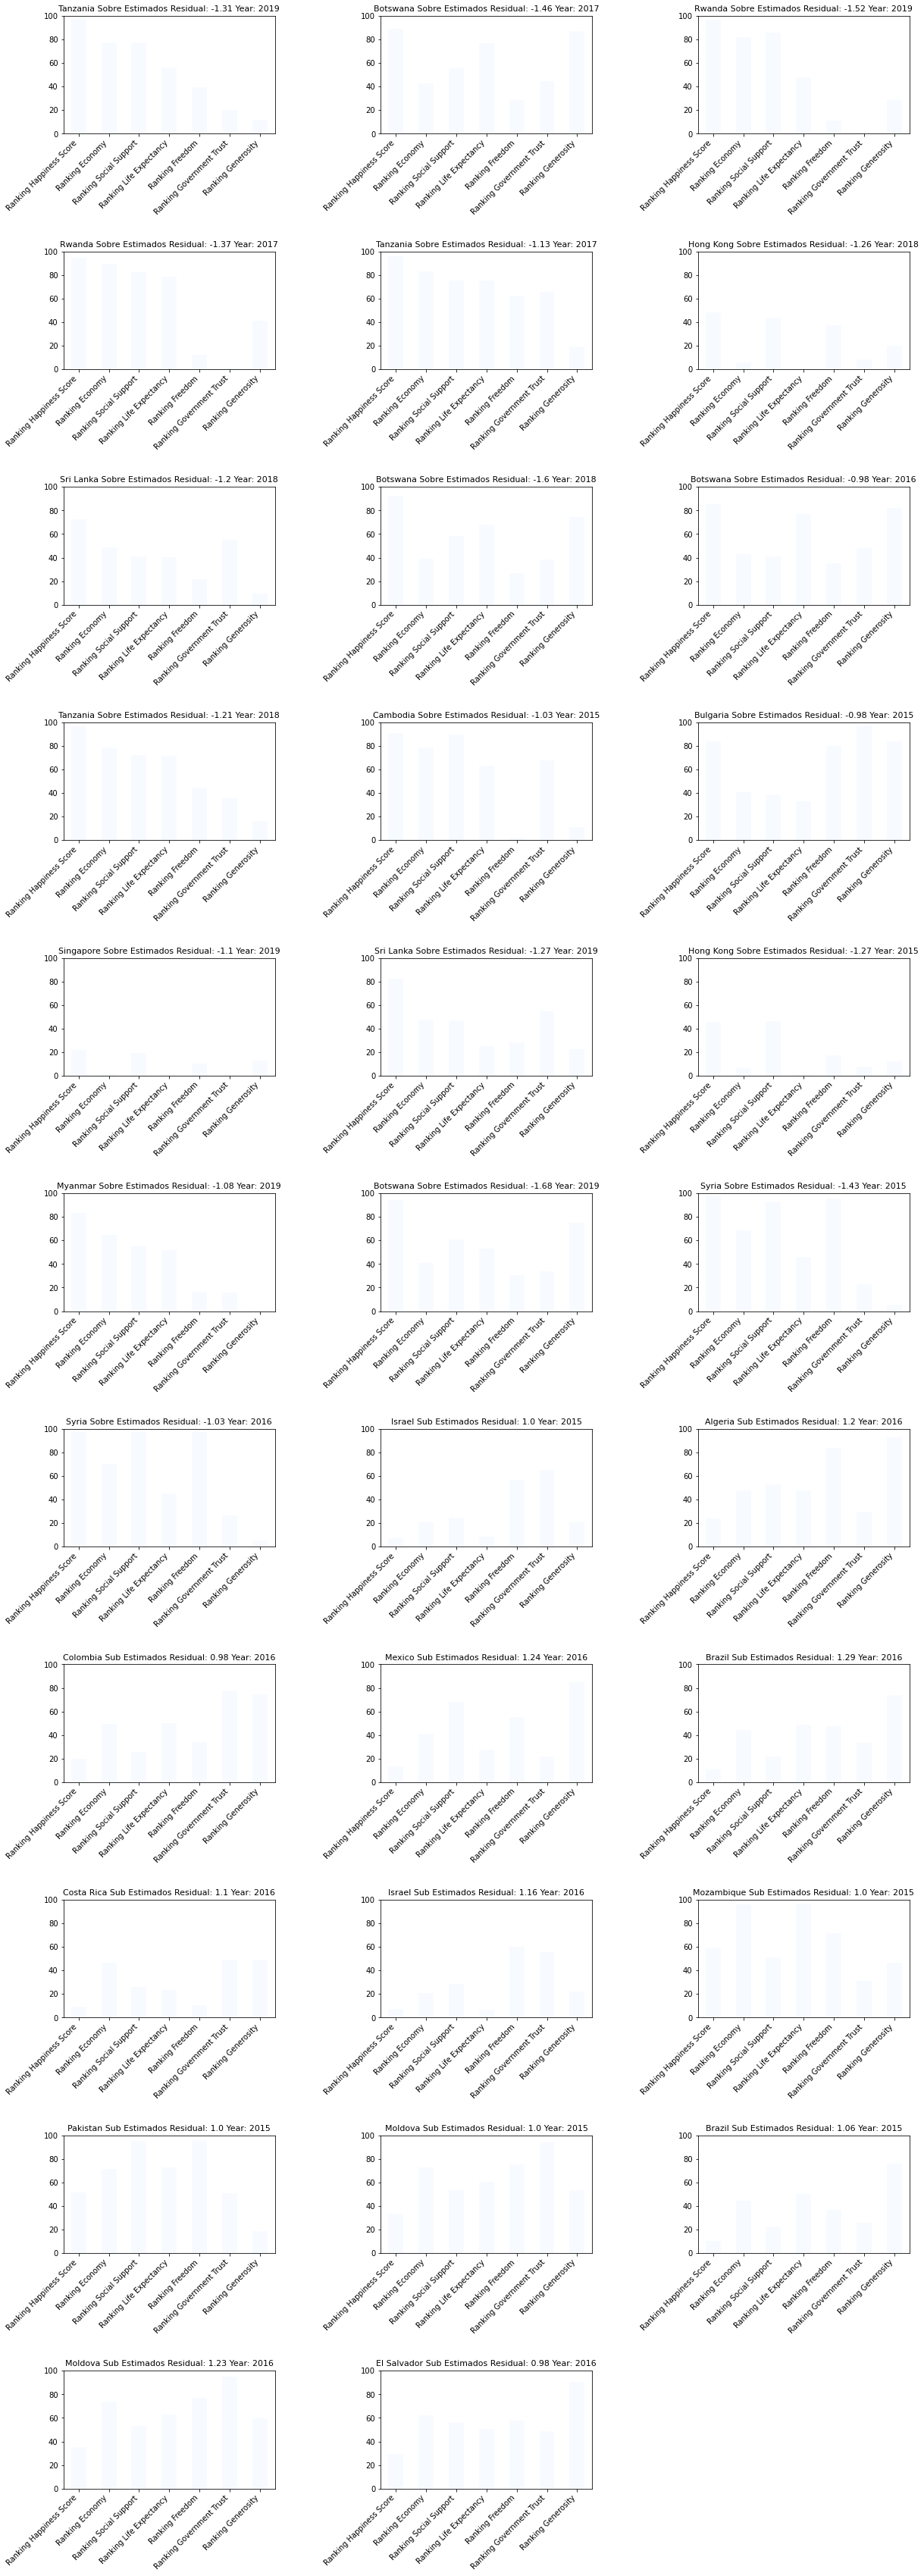

In [117]:
#Verifying data distribution for each year
fig = plt.figure(figsize=(20,60))
i=0
n=df_tb.count()[0]
for ind in list(df_tb.index):  
    ax=plt.subplot(int(np.ceil(n/3)),3,i+1)
    ax.set_ylim([0,100])
    
    df_tb.loc[ind].iloc[10:17].plot(kind='bar', colormap='Blues')
    
    t=str(df_tb.loc[ind].iloc[9]+' '+df_tb.loc[ind].iloc[18]+' Residual: '+
          str(round(df_tb.loc[ind].iloc[17],2))+' Year: '+df_tb.loc[ind].iloc[7])
    ax.set_title(t,fontsize=11)
    plt.xticks(rotation=45,ha='right');
    i+=1
plt.subplots_adjust(hspace=1,wspace=0.5)